In [1]:
using CSV
using DataFrames
using Dates
using ProgressMeter
using Gadfly

In [2]:
ENV["COLUMNS"] = 1000;

In [3]:
rawdata = DataFrame(CSV.File("../rawdata/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility_2021_03_07.csv"));

In [4]:
bad_ids = begin
    id_counts = combine(groupby(rawdata, :hospital_pk), :hospital_name => (x -> length(unique(x))) => :n_names)
    filter!(x -> x.n_names > 1, id_counts)
    unique(id_counts.hospital_pk)
end
filter!(row -> !(row.hospital_pk in bad_ids), rawdata);

In [5]:
data_weekly = select(rawdata,
    :hospital_name => :hospital,
    :hospital_pk => :hospital_id,
    :collection_week => ByRow(d -> Date(d, "mm/dd/yyyy HH:MM:SS p")) => :date,
    
    :previous_day_admission_adult_covid_confirmed_7_day_sum => ByRow(x -> (ismissing(x) || x == -999999) ? missing : x) => :admissions_weekly_allbeds,
    :total_adult_patients_hospitalized_confirmed_covid_7_day_sum => ByRow(x -> (ismissing(x) || x == -999999) ? missing : x) => :active_weekly_allbeds,
    :staffed_icu_adult_patients_confirmed_covid_7_day_sum => ByRow(x -> (ismissing(x) || x == -999999) ? missing : x) => :active_weekly_icu,
);
data_weekly.active_weekly_acute = data_weekly.active_weekly_allbeds - data_weekly.active_weekly_icu
sort!(data_weekly, [:hospital, :hospital_id, :date]);

In [6]:
first(data_weekly, 50)

,hospital,hospital_id,date,admissions_weekly_allbeds,active_weekly_allbeds,active_weekly_icu,active_weekly_acute
,String,String,Date,Int64?,Int64?,Int64?,Int64?
1,ABBEVILLE AREA MEDICAL CENTER,421301,2020-07-31,11,22,12,10
2,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-07,7,31,6,25
3,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-14,missing,missing,0,missing
4,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-21,missing,15,0,15
5,ABBEVILLE AREA MEDICAL CENTER,421301,2020-08-28,10,10,0,10
6,ABBEVILLE AREA MEDICAL CENTER,421301,2020-09-04,9,16,0,16
7,ABBEVILLE AREA MEDICAL CENTER,421301,2020-09-11,7,14,0,14
8,ABBEVILLE AREA MEDICAL CENTER,421301,2020-09-18,5,10,0,10
9,ABBEVILLE AREA MEDICAL CENTER,421301,2020-09-25,0,0,0,0


In [7]:
function interpolate_timeseries_linear(xs_, ys)
    x_start = xs_[1]
    xs = [(x-x_start).value for x in xs_]
    
    tx = length(xs)
    
    d_start, d_end = xs[1], xs[end]
    ds = 0 : (d_end-d_start)
    
    td = length(ds)
    zs = zeros(Union{Float64,Missing}, td)
    
    for (i,d) in enumerate(ds)
        x1_ind = findlast(q -> q <= d, xs)
        x1_ind = isnothing(x1_ind) ? tx : x1_ind
        
        x1 = xs[x1_ind]
        x2 = xs[min(x1_ind+1, tx)]
        
        y1 = ys[x1_ind]
        y2 = ys[min(x1_ind+1, tx)]
        
        m = (x1==x2) ? 0 : (y2-y1) / (x2-x1)
        z = (m * (d-x1)) + y1
        zs[i] = max(0, z)
    end
    
    return zs
end;

In [8]:
data_daily_list = []
@showprogress for loc_df in groupby(data_weekly, :hospital_id)
    loc_df = sort(loc_df, :date)
    
    h_name = loc_df.hospital[1]
    h_id = loc_df.hospital_id[1]
    
    dates_w = loc_df.date

    admissions_allbeds_d = interpolate_timeseries_linear(dates_w, loc_df.admissions_weekly_allbeds ./ 7)
    active_allbeds_d = interpolate_timeseries_linear(dates_w, loc_df.active_weekly_allbeds ./ 7)
    active_icu_d = interpolate_timeseries_linear(dates_w, loc_df.active_weekly_icu ./ 7)
    active_acute_d = active_allbeds_d - active_icu_d
    
    start_date = dates_w[1]
    end_date   = dates_w[end]
    dates_d = collect(start_date : Day(1) : end_date)
    
    t = length(dates_d)
    loc_df_daily = DataFrame(
        hospital = fill(h_name, t),
        hospital_id = fill(h_id, t),
        date = dates_d,
        admissions_icu = admissions_allbeds_d .* 0.3,
        admissions_acute = admissions_allbeds_d .* 0.7,
        admissions_allbeds = admissions_allbeds_d,
        active_icu = active_icu_d,
        active_acute = active_acute_d,
        active_allbeds = active_allbeds_d,
    )
    push!(data_daily_list, loc_df_daily)
end
data_daily = vcat(data_daily_list...);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [9]:
data_daily |> CSV.write("../data/hhs_data_2021_03_07.csv");

In [10]:
isbad(x) = ismissing(x) || isnan(x) || isinf(x);
skipbad(xs) = filter(x -> !isbad(x), xs);

In [11]:
data_daily_total = combine(groupby(data_daily, :date), [
    :admissions_allbeds => (x -> sum(skipbad(x))) => :admissions_allbeds_total,
    :active_allbeds => (x -> sum(skipbad(x))) => :active_allbeds_total,
    :active_icu => (x -> sum(skipbad(x))) => :active_icu_total,
    :active_acute => (x -> sum(skipbad(x))) => :active_acute_total,
]);

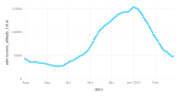

In [12]:
plot(
    data_daily_total,
    x = :date,
    y = :admissions_allbeds_total,
    Geom.point,
    Coord.cartesian(ymin=0),
    Scale.y_continuous(format=:plain),
) |> SVG(18cm, 10cm)

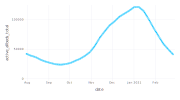

In [13]:
plot(
    data_daily_total,
    x = :date,
    y = :active_allbeds_total,
    Coord.cartesian(ymin=0),
    Scale.y_continuous(format=:plain),
) |> SVG(18cm, 10cm)